In [61]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from checkerboard import detect_checkerboard

In [195]:
img_names = [os.path.join('data/', name) for name in os.listdir('data')]
print(len(img_names))

974


(482, 644, 3)


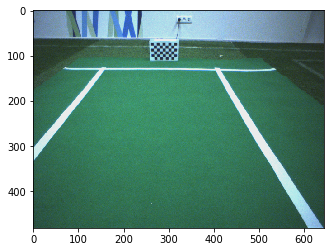

In [196]:
img = cv2.imread(img_names[300])
rgb_img  = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
print(img.shape)
plt.imshow(rgb_img, cmap='gray')

In [197]:
def select_white_color(image):
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    return cv2.bitwise_and(image, image, mask=white_mask)

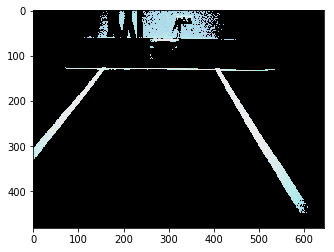

In [198]:
white_color = select_white_color(rgb_img)
plt.imshow(white_color)

In [199]:
def find_edges(image, low_threshold=50, high_threshold=150, kernel_size=15):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return cv2.Canny(image, low_threshold, high_threshold)

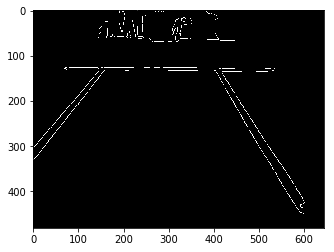

In [200]:
edges = find_edges(white_color)
plt.imshow(edges, cmap='gray')

In [201]:
def draw_verticies(orig_image, verticies):
    image = orig_image.copy()
    for vert in verticies:
        pt1, pt2, pt3, pt4 = vert
        pt1, pt2, pt3, pt4 = tuple(pt1), tuple(pt2), tuple(pt3), tuple(pt4)
        cv2.line(image, pt1, pt2, (255,0,0), 2)
        cv2.line(image, pt2, pt3, (255,0,0), 2)
        cv2.line(image, pt3, pt4, (255,0,0), 2)
        cv2.line(image, pt4, pt1, (255,0,0), 2)
    return image

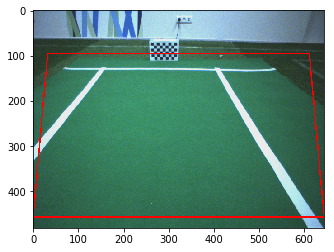

In [204]:
#ROI
rows, cols = img.shape[:2]
bottom_left  = (cols*0.0, rows*0.95)
top_left     = (cols*0.05, rows*0.2)
bottom_right = (cols*1.0, rows*0.95)
top_right    = (cols*0.95, rows*0.2)
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

roi_display = draw_verticies(rgb_img, vertices)
plt.figure()
plt.imshow(roi_display, cmap='gray')

In [209]:
def select_region(image, verticies):
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2])  
        
    return cv2.bitwise_and(image, mask)

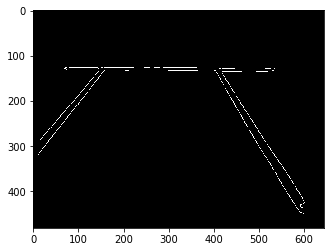

In [210]:
roi_image = select_region(edges, vertices)
plt.figure()
plt.imshow(roi_image, cmap='gray')

In [213]:
def detect_lines(image):
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)

def draw_hough_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

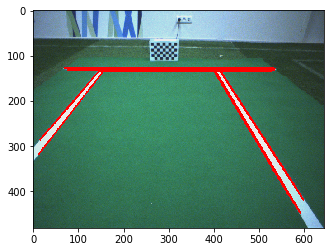

In [257]:
list_of_lines = detect_lines(roi_image)

displayed_img = draw_hough_lines(rgb_img, list_of_lines)
plt.imshow(displayed_img)

In [278]:
def average_slope_vertical_lines(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = []
    right_weights = []
    front_lines = []
    front_weights = []
    
    SLOPE_THRESHOLD = 0.2
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if abs(slope) < SLOPE_THRESHOLD: #Filter out all extra lines
                continue
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
#     for line in lines:
#         for x1, y1, x2, y2 in line:
#             if y2==y1:
#                 continue
#             slope = (x2 - x1) / (y2 - y1)
#             intercept = x1 - slope*y1
#             length = np.sqrt((y2-y1)**2+(x2-x1)**2)
#             if abs((y2-y1)/(x2-x1)) < SLOPE_THRESHOLD:
#                 front_lines.append((slope, intercept))
#                 front_weights.append((length))
                
#     front_lane = np.dot(front_weights, front_lines)/np.sum(front_weights) if len(front_weights)>0 else None
    return left_lane, right_lane

def make_line_points_vert(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

def make_line_points_hori(x1, x2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    y1 = int((x1 - intercept)/slope)
    y2 = int((x2 - intercept)/slope)
    x1 = int(x1)
    x2 = int(x2)
    
    return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
    left_lane, right_lane, front_lane = average_slope_intercept(lines)

    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.3         # slightly lower than the middle
    
    x1 = 0              # left side of the image
    x2 = image.shape[0] # right side of the image

    left_line  = make_line_points_vert(y1, y2, left_lane)
    right_line = make_line_points_vert(y1, y2, right_lane)
    #front_line = make_line_points_hori(x1, x2, front_lane)
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)

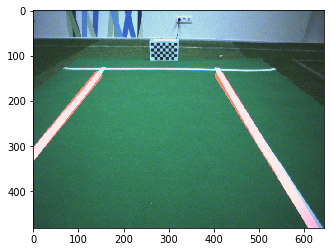

In [279]:
averaged_lines_img = draw_lane_lines(rgb_img, lane_lines(rgb_img, list_of_lines))
plt.imshow(averaged_lines_img)